In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/MyDrive/responsive-ai'

/content/drive/MyDrive/responsive-ai


## Dependencies

In [ ]:
!pip install quantus
!pip install captum==0.7.0
!pip install ptflops
!pip install fairlearn

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
from typing import Optional
from IPython.display import Markdown, display, clear_output
import time
from tqdm import tqdm
import shap
import quantus
from fairlearn.datasets import fetch_diabetes_hospital


# Data

## Data Loading

In [ ]:
# ---------------------------
# Data Loading and Preparation
# ---------------------------

X, y = fetch_diabetes_hospital(as_frame=True, return_X_y=True)
# The columns readmit_binary and readmitted are included in X -> remove both to avoid target leakage
X.drop(columns=["readmitted", "readmit_binary"], inplace=True)


## Preprocessing

### Remove Unknown/Invalid gender

In [ ]:
# Get a boolean mask for rows where gender is not 'Unknown/Invalid' (which was encoded as 2)
valid_gender_mask = X['gender'] != 'Unknown/Invalid'

In [ ]:
# Filter both X and y using the same mask
X = X[valid_gender_mask]
y = y[valid_gender_mask]

In [ ]:
print("Remaining rows after removing 'Unknown/Invalid' gender values:")
print(X['gender'].value_counts())

Remaining rows after removing 'Unknown/Invalid' gender values:
gender
Female    54708
Male      47055
Name: count, dtype: int64


### Label Encoding

In [ ]:
X_copy = X.copy()
categorical_cols = X_copy.select_dtypes(include=['object', 'category']).columns

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_mappings = {}
# Apply LabelEncoder to each column and store mappings
for col in categorical_cols:
    le = LabelEncoder()
    X_copy[col] = le.fit_transform(X_copy[col])
    label_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))

# Show mappings
for col, mapping in label_mappings.items():
    print(f"\nEncoded mapping for '{col}':")
    for original, encoded in mapping.items():
        print(f"  {original} → {encoded}")


Encoded mapping for 'race':
  AfricanAmerican → 0
  Asian → 1
  Caucasian → 2
  Hispanic → 3
  Other → 4
  Unknown → 5

Encoded mapping for 'gender':
  Female → 0
  Male → 1

Encoded mapping for 'age':
  '30 years or younger' → 0
  '30-60 years' → 1
  'Over 60 years' → 2

Encoded mapping for 'discharge_disposition_id':
  'Discharged to Home' → 0
  Other → 1

Encoded mapping for 'admission_source_id':
  Emergency → 0
  Other → 1
  Referral → 2

Encoded mapping for 'medical_specialty':
  Cardiology → 0
  Emergency/Trauma → 1
  Family/GeneralPractice → 2
  InternalMedicine → 3
  Missing → 4
  Other → 5

Encoded mapping for 'primary_diagnosis':
  'Genitourinary Issues' → 0
  'Musculoskeletal Issues' → 1
  'Respiratory Issues' → 2
  Diabetes → 3
  Other → 4

Encoded mapping for 'max_glu_serum':
  >200 → 0
  >300 → 1
  None → 2
  Norm → 3

Encoded mapping for 'A1Cresult':
  >7 → 0
  >8 → 1
  None → 2
  Norm → 3

Encoded mapping for 'insulin':
  Down → 0
  No → 1
  Steady → 2
  Up → 3

Encod

In [ ]:
X_encoded = X_copy.copy()

In [ ]:
X_encoded.head(5)

,race,gender,age,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,max_glu_serum,A1Cresult,insulin,change,diabetesMed,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days
0,2,0,0,1,2,1,5,41,0,1,...,2,2,1,1,0,0,0,0,0,0
1,2,0,0,0,0,3,4,59,0,18,...,2,2,3,0,1,0,0,0,0,0
2,0,0,0,0,0,2,4,11,5,13,...,2,2,1,1,1,0,0,0,1,1
3,2,1,1,0,0,2,4,44,1,16,...,2,2,3,0,1,0,0,0,0,0
4,2,1,1,0,0,1,4,51,0,8,...,2,2,2,0,1,0,0,0,0,0


### Splitting & Formatting

In [ ]:
random_state = 7

In [ ]:
##  Split into training and test sets (we use test for evaluation and explanations)

X_trainval, X_test, y_trainval, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=random_state, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=random_state, stratify=y_trainval)

In [ ]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (65128, 22)
X_test shape: (20353, 22)
y_train shape: (65128,)
y_test shape: (20353,)
X_val shape: (16282, 22)
y_val shape: (16282,)


In [ ]:
# Convert to numpy arrays
X_train_np = X_train.values.astype(np.float32)
X_val_np = X_val.values.astype(np.float32)
X_test_np = X_test.values.astype(np.float32)

# For CrossEntropyLoss, labels must be integers.
y_train_np = y_train.astype(np.int64).values if isinstance(y_train, pd.Series) else y_train.astype(np.int64)
y_val_np = y_val.astype(np.int64).values if isinstance(y_val, pd.Series) else y_val.astype(np.int64)
y_test_np = y_test.astype(np.int64).values if isinstance(y_test, pd.Series) else y_test.astype(np.int64)

# Create PyTorch tensors
X_train_t = torch.from_numpy(X_train_np)
y_train_t = torch.from_numpy(y_train_np)
X_val_t = torch.from_numpy(X_val_np)
y_val_t = torch.from_numpy(y_val_np)
X_test_t = torch.from_numpy(X_test_np)
y_test_t = torch.from_numpy(y_test_np)

### Dataloader

In [ ]:
batch_size = 200

train_ds = TensorDataset(
    X_train_t,
    y_train_t
)
val_ds = TensorDataset(
    X_val_t,
    y_val_t
)
test_ds = TensorDataset(
    X_test_t,
    y_test_t
)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)


# Train

## MLP

### MLP Model

In [ ]:
INPUT_DIM     = X_test_np.shape[1]
NUM_CLASSES   = 2
HIDDEN_DIM    = 50
LEARNING_RATE = 1e-3

torch.manual_seed(random_state)

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        # Initialize weights uniformly in [-1/√fan_in, +1/√fan_in]
        nn.init.uniform_(self.fc1.weight,
                         a=-1.0 / (input_dim**0.5),
                         b=+1.0 / (input_dim**0.5))
        nn.init.zeros_(self.fc1.bias)
        nn.init.uniform_(self.fc2.weight,
                         a=-1.0 / (hidden_dim**0.5),
                         b=+1.0 / (hidden_dim**0.5))
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x  # raw logits

# Instantiate and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp_model = MLP(INPUT_DIM, HIDDEN_DIM, NUM_CLASSES).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=LEARNING_RATE)

### Train

In [ ]:
best_val_loss = float('inf')
patience = 20   # Early stopping patience
epochs_no_improve = 0

num_epochs = 400
start_time = time.time()
for epoch in range(num_epochs):
    mlp_model.train()

    X_train_t = X_train_t.to(device)
    y_train_t = y_train_t.to(device)
    X_val_t = X_val_t.to(device)
    y_val_t = y_val_t.to(device)
    X_test_t = X_test_t.to(device)
    y_test_t = y_test_t.to(device)

    logits = mlp_model(X_train_t)
    loss = criterion(logits, y_train_t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_train_pred = torch.argmax(logits, dim=1)
    train_accuracy = accuracy_score(y_train_t.cpu().numpy(), y_train_pred.cpu().numpy())

    mlp_model.eval()
    with torch.no_grad():
        val_logits = mlp_model(X_val_t)
        val_loss = criterion(val_logits, y_val_t)
        val_pred = torch.argmax(val_logits, dim=1)
        val_accuracy = accuracy_score(y_val_t.cpu().numpy(), val_pred.cpu().numpy())

    if ((epoch + 1) % 50) == 0 or (epoch + 1 == 1):
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Training Loss: {loss.item():.4f}   - Training Accuracy: {train_accuracy:.4f}")
        print(f"Validation Loss: {val_loss.item():.4f} - Validation Accuracy: {val_accuracy:.4f} \n")

    # Check for improvement in validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs.")
            break

# Evaluate on test data
mlp_model.eval()
with torch.no_grad():
    logits = mlp_model(X_test_t)
    probs = torch.softmax(logits, dim=1)
    preds = torch.argmax(probs, dim=1)
    accuracy = (preds == y_test_t).float().mean().item()
    print(f"\nTest Accuracy: {accuracy:.4f}")

end_time = time.time()
mlp_elapsed_time = end_time - start_time

Epoch [1/400]
Training Loss: 1.4216   - Training Accuracy: 0.1222
Validation Loss: 1.0807 - Validation Accuracy: 0.1993 

Epoch [50/400]
Training Loss: 0.3661   - Training Accuracy: 0.8884
Validation Loss: 0.3681 - Validation Accuracy: 0.8884 

Epoch [100/400]
Training Loss: 0.3522   - Training Accuracy: 0.8884
Validation Loss: 0.3524 - Validation Accuracy: 0.8884 

Epoch [150/400]
Training Loss: 0.3473   - Training Accuracy: 0.8884
Validation Loss: 0.3471 - Validation Accuracy: 0.8884 

Epoch [200/400]
Training Loss: 0.3439   - Training Accuracy: 0.8884
Validation Loss: 0.3439 - Validation Accuracy: 0.8884 

Epoch [250/400]
Training Loss: 0.3417   - Training Accuracy: 0.8884
Validation Loss: 0.3420 - Validation Accuracy: 0.8884 

Epoch [300/400]
Training Loss: 0.3402   - Training Accuracy: 0.8884
Validation Loss: 0.3407 - Validation Accuracy: 0.8884 

Epoch [350/400]
Training Loss: 0.3390   - Training Accuracy: 0.8884
Validation Loss: 0.3397 - Validation Accuracy: 0.8884 

Epoch [400/

In [ ]:
print("\nTotal training time: ", mlp_elapsed_time)


Total training time:  2.5444562435150146


In [ ]:
# Save the model
torch.save(mlp_model.state_dict(), "saved_model/mlp_diabetes.pth")

### Eval

In [ ]:
# Load the model
mlp_model.load_state_dict(torch.load("saved_model/mlp_diabetes.pth"))

<All keys matched successfully>

In [ ]:
# Evaluate on test data
X_test_t = X_test_t.to(device)
y_test_t = y_test_t.to(device)
mlp_model.eval()
with torch.no_grad():
    logits = mlp_model(X_test_t)
    probs = torch.softmax(logits, dim=1)
    preds = torch.argmax(probs, dim=1)
    accuracy = (preds == y_test_t).float().mean().item()
    print(f"\nTest Accuracy: {accuracy:.4f}")


Test Accuracy: 0.8884


### Train with bs

In [ ]:
patience = 20
best_val_loss = float('inf')
epochs_no_improve = 0

num_epochs = 400
start_time = time.time()
for epoch in range(num_epochs):
    mlp_model.train()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch:02d} [Train]", leave=False):
        xb, yb = xb.to(device), yb.to(device)
        logits = mlp_model(xb)                    # shape (batch_size, 2)
        loss = criterion(logits, yb)              # cross-entropy on 2 logits\
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += float(loss.item()) * xb.size(0)
        # Convert logits → predicted class indices, move back to CPU
        preds = logits.argmax(dim=1).cpu().numpy()   # shape (batch_size,)
        labels = yb.cpu().numpy()                    # shape (batch_size,)

        all_preds.append(preds)
        all_labels.append(labels)

    # Concatenate batches for the full epoch
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    train_loss = total_loss / len(train_loader.dataset)

    # Validate
    mlp_model.eval()
    total_val_loss = 0.0
    all_val_preds = []
    all_val_labels = []
    with torch.no_grad():
        for xb, yb in tqdm(val_loader, desc=f"Epoch {epoch:02d} [Val]  ", leave=False):
            xb, yb = xb.to(device), yb.to(device)
            logits = mlp_model(xb)             # shape (batch_size, 2)
            loss = criterion(logits, yb)

            total_val_loss += float(loss.item()) * xb.size(0)

            preds = logits.argmax(dim=1).cpu().numpy()
            labels = yb.cpu().numpy()
            all_val_preds.append(preds)
            all_val_labels.append(labels)

    # Finalize validation metrics for this epoch
    all_val_preds = np.concatenate(all_val_preds, axis=0)
    all_val_labels = np.concatenate(all_val_labels, axis=0)
    val_loss = total_val_loss / len(val_loader.dataset)

    if ((epoch + 1) % 50) == 0 or (epoch + 1 == 1):
        print(f"Epoch [{epoch+1}/{num_epochs}]:")
        train_acc  = accuracy_score(all_labels, all_preds)
        val_acc = accuracy_score(all_val_labels, all_val_preds)
        print(f"Training loss = {train_loss:.4f}  -  Training Accuracy = {train_acc:.4f}  -  Val Accuracy:{val_acc:.4f}")

    # # Check for improvement in validation loss
    # if val_loss < best_val_loss:
    #     best_val_loss = val_loss
    #     epochs_no_improve = 0
    # else:
    #     epochs_no_improve += 1
    #     if epochs_no_improve >= patience:
    #         print(f"\nEarly stopping triggered after {epoch+1} epochs.")
    #         break

# Eval
mlp_model.eval()
test_preds, test_targets = [], []
with torch.no_grad():
    for xb, yb in tqdm(test_loader, desc="Testing", leave=False):
        xb, yb = xb.to(device), yb.to(device)
        logits = mlp_model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()
        labels = yb.cpu().numpy()
        test_preds.append(preds)
        test_targets.append(labels)

test_acc = accuracy_score(
    np.concatenate(test_targets),
    np.concatenate(test_preds)
)
print(f"Test Accuracy: {test_acc:.4f}")

end_time = time.time()
mlp_elapsed_time = end_time - start_time

In [ ]:
print("\nTotal training time: ", mlp_elapsed_time)


Total training time:  169.8198699951172


In [ ]:
# Save the model
torch.save(mlp_model.state_dict(), "saved_model/mlp_adults.pth")

### Eval with bs

In [ ]:
# Load the model
mlp_model.load_state_dict(torch.load("saved_model/mlp_adults.pth"))

<All keys matched successfully>

In [ ]:
mlp_model.eval()
test_preds, test_targets = [], []
with torch.no_grad():
    for xb, yb in tqdm(test_loader, desc="Testing", leave=False):
        xb, yb = xb.to(device), yb.to(device)
        logits = mlp_model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()
        labels = yb.cpu().numpy()
        test_preds.append(preds)
        test_targets.append(labels)

test_acc = accuracy_score(
    np.concatenate(test_targets),
    np.concatenate(test_preds)
)
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.8488


## TabResNet

### Model TabResNet

In [ ]:
# ---------------------------
# Model Definition: TabResNet (using residual blocks)
# ---------------------------
class TabResBlock(nn.Module):
    def __init__(self, d_block, d_hidden, dropout1, dropout2):
        super(TabResBlock, self).__init__()
        # Sub-block 1
        self.bn1 = nn.BatchNorm1d(d_block)
        self.ln1 = nn.Linear(d_block, d_hidden)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(dropout1)
        # Sub-block 2
        self.ln2 = nn.Linear(d_hidden, d_block)
        self.drop2 = nn.Dropout(dropout2)

    def forward(self, x):
        identity = x
        out = self.bn1(x)
        out = self.ln1(out)
        out = self.relu1(out)
        out = self.drop1(out)
        out = self.ln2(out)
        out = self.drop2(out)
        out += identity
        return out

class TabResNet(nn.Module):
    def __init__(
        self,
        d_in: int,
        d_out: Optional[int],
        n_blocks: int,
        d_block: int,
        d_hidden: Optional[int],
        d_hidden_multiplier: Optional[float] = 2,
        dropout1: float = 0.2,
        dropout2: float = 0
    ):
        """
        Args:
            d_in: Number of input features.
            d_out: Number of outputs (set to 2 for binary classification).
            n_blocks: Number of residual blocks.
            d_block: Block width (input and output dimension of each block).
            d_hidden: Hidden dimension inside a block.
        """
        super(TabResNet, self).__init__()
        # Project input to block width
        self.input_projection = nn.Linear(d_in, d_block)
        # Residual blocks
        self.resblocks = nn.ModuleList([
            TabResBlock(d_block, d_hidden, dropout1, dropout2) for _ in range(n_blocks)
        ])
        # Prediction block: outputs logits for d_out classes.
        self.predblock = (
            nn.Sequential(
                nn.BatchNorm1d(d_block),
                nn.ReLU(),
                nn.Linear(d_block, d_out)
            ) if d_out is not None else None
        )

    def forward(self, x):
        x = self.input_projection(x)
        for block in self.resblocks:
            x = block(x)
        if self.predblock is not None:
            x = self.predblock(x)
        return x  # returns logits


# Instantiate model; input dimension equals the number of columns in X_test_np.
d_in = X_test_np.shape[1]
model = TabResNet(
    d_in=d_in,
    d_out=2,       # Two outputs for binary classification.
    n_blocks=2,
    d_block=16,
    d_hidden=32,
    dropout1=0.2,
    dropout2=0.05
    )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### Train

In [ ]:
best_val_loss = float('inf')
patience = 30   # Early stopping patience
counter = 0

num_epochs = 400
start_time = time.time()
for epoch in range(num_epochs):
    model.train()

    X_train_t = X_train_t.to(device)
    y_train_t = y_train_t.to(device)
    X_val_t = X_val_t.to(device)
    y_val_t = y_val_t.to(device)
    X_test_t = X_test_t.to(device)
    y_test_t = y_test_t.to(device)

    logits = model(X_train_t)
    loss = criterion(logits, y_train_t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    y_train_pred = torch.argmax(logits, dim=1)
    train_accuracy = accuracy_score(y_train_t.cpu().numpy(), y_train_pred.cpu().numpy())

    model.eval()
    with torch.no_grad():
        val_logits = model(X_val_t)
        val_loss = criterion(val_logits, y_val_t)
        val_pred = torch.argmax(val_logits, dim=1)
        val_accuracy = accuracy_score(y_val_t.cpu().numpy(), val_pred.cpu().numpy())

    if ((epoch + 1) % 50) == 0 or (epoch + 1 == 1):
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Training Loss: {loss.item():.4f}   - Training Accuracy: {train_accuracy:.4f}")
        print(f"Validation Loss: {val_loss.item():.4f} - Validation Accuracy: {val_accuracy:.4f} \n")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Evaluate on test data
model.eval()
with torch.no_grad():
    logits = model(X_test_t)
    probs = torch.softmax(logits, dim=1)
    preds = torch.argmax(probs, dim=1)
    accuracy = (preds == y_test_t).float().mean().item()
    print(f"\nTest Accuracy: {accuracy:.4f}")

end_time = time.time()
elapsed_time = end_time - start_time

Epoch [1/400]
Training Loss: 0.6591   - Training Accuracy: 0.6162
Validation Loss: 1.4218 - Validation Accuracy: 0.1722 

Epoch [50/400]
Training Loss: 0.4284   - Training Accuracy: 0.8884
Validation Loss: 0.4420 - Validation Accuracy: 0.8884 

Epoch [100/400]
Training Loss: 0.3573   - Training Accuracy: 0.8884
Validation Loss: 0.3551 - Validation Accuracy: 0.8884 

Epoch [150/400]
Training Loss: 0.3421   - Training Accuracy: 0.8884
Validation Loss: 0.3413 - Validation Accuracy: 0.8884 

Epoch [200/400]
Training Loss: 0.3391   - Training Accuracy: 0.8884
Validation Loss: 0.3394 - Validation Accuracy: 0.8884 

Epoch [250/400]
Training Loss: 0.3377   - Training Accuracy: 0.8884
Validation Loss: 0.3387 - Validation Accuracy: 0.8884 

Epoch [300/400]
Training Loss: 0.3367   - Training Accuracy: 0.8884
Validation Loss: 0.3386 - Validation Accuracy: 0.8884 

Epoch [350/400]
Training Loss: 0.3362   - Training Accuracy: 0.8884
Validation Loss: 0.3381 - Validation Accuracy: 0.8884 

Early stopp

In [ ]:
print("\nTotal training time: ", elapsed_time)


Total training time:  3.188084363937378


In [ ]:
# Save the model
torch.save(model.state_dict(), "saved_model/tabresnet_diabetes.pth")

### Eval

In [ ]:
# Load the model
model.load_state_dict(torch.load("saved_model/tabresnet_adults.pth"))

<All keys matched successfully>

In [ ]:
X_test_t = X_test_t.to(device)
y_test_t = y_test_t.to(device)
model.eval()
with torch.no_grad():
    logits = model(X_test_t)
    probs = torch.softmax(logits, dim=1)
    preds = torch.argmax(probs, dim=1)
    accuracy = (preds == y_test_t).float().mean().item()
    print(f"\nTest Accuracy: {accuracy:.4f}")


Test Accuracy: 0.8884


### Training with bs

In [ ]:
patience = 20
best_val_loss = float('inf')
epochs_no_improve = 0

num_epochs = 400
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch:02d} [Train]", leave=False):
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)                    # shape (batch_size, 2)
        loss = criterion(logits, yb)              # cross-entropy on 2 logits\
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += float(loss.item()) * xb.size(0)
        # Convert logits → predicted class indices, move back to CPU
        preds = logits.argmax(dim=1).cpu().numpy()   # shape (batch_size,)
        labels = yb.cpu().numpy()                    # shape (batch_size,)

        all_preds.append(preds)
        all_labels.append(labels)

    # Concatenate batches for the full epoch
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    train_loss = total_loss / len(train_loader.dataset)

    # Validate
    model.eval()
    total_val_loss = 0.0
    all_val_preds = []
    all_val_labels = []
    with torch.no_grad():
        for xb, yb in tqdm(val_loader, desc=f"Epoch {epoch:02d} [Val]  ", leave=False):
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)             # shape (batch_size, 2)
            loss = criterion(logits, yb)

            total_val_loss += float(loss.item()) * xb.size(0)

            preds = logits.argmax(dim=1).cpu().numpy()
            labels = yb.cpu().numpy()
            all_val_preds.append(preds)
            all_val_labels.append(labels)

    # Finalize validation metrics for this epoch
    all_val_preds = np.concatenate(all_val_preds, axis=0)
    all_val_labels = np.concatenate(all_val_labels, axis=0)
    val_loss = total_val_loss / len(val_loader.dataset)

    if ((epoch + 1) % 50) == 0 or (epoch + 1 == 1):
        print(f"Epoch [{epoch+1}/{num_epochs}]:")
        train_acc  = accuracy_score(all_labels, all_preds)
        val_acc = accuracy_score(all_val_labels, all_val_preds)
        print(f"Training loss = {train_loss:.4f}  -  Training Accuracy = {train_acc:.4f}  -  Val Accuracy:{val_acc:.4f}")

    # # Check for improvement in validation loss
    # if val_loss < best_val_loss:
    #     best_val_loss = val_loss
    #     epochs_no_improve = 0
    # else:
    #     epochs_no_improve += 1
    #     if epochs_no_improve >= patience:
    #         print(f"\nEarly stopping triggered after {epoch+1} epochs.")
    #         break

# Evaluate on test data
model.eval()
test_preds, test_targets = [], []
with torch.no_grad():
    for xb, yb in tqdm(test_loader, desc="Testing", leave=False):
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()
        labels = yb.cpu().numpy()
        test_preds.append(preds)
        test_targets.append(labels)

test_acc = accuracy_score(
    np.concatenate(test_targets),
    np.concatenate(test_preds)
)
print(f"Test Accuracy: {test_acc:.4f}")

end_time = time.time()
elapsed_time = end_time - start_time

Epoch [1/400]:
Training loss = 0.6236  -  Training Accuracy = 0.7778  -  Val Accuracy:0.7969


Epoch [50/400]:
Training loss = 0.3382  -  Training Accuracy = 0.8434  -  Val Accuracy:0.8420


Epoch [100/400]:
Training loss = 0.3301  -  Training Accuracy = 0.8464  -  Val Accuracy:0.8468


Epoch [150/400]:
Training loss = 0.3264  -  Training Accuracy = 0.8477  -  Val Accuracy:0.8461


Epoch [200/400]:
Training loss = 0.3261  -  Training Accuracy = 0.8451  -  Val Accuracy:0.8461


Epoch [250/400]:
Training loss = 0.3230  -  Training Accuracy = 0.8476  -  Val Accuracy:0.8476


Epoch [300/400]:
Training loss = 0.3192  -  Training Accuracy = 0.8505  -  Val Accuracy:0.8480


Epoch [350/400]:
Training loss = 0.3185  -  Training Accuracy = 0.8503  -  Val Accuracy:0.8484


Epoch [400/400]:
Training loss = 0.3160  -  Training Accuracy = 0.8516  -  Val Accuracy:0.8476


Test Accuracy: 0.8501


In [ ]:
print("\nTotal training time: ", elapsed_time)


Total training time:  262.14256858825684


In [ ]:
# Save the model
torch.save(model.state_dict(), "saved_model/tabresnet_adults.pth")

### Eval with bs

In [ ]:
# Load the model
model.load_state_dict(torch.load("saved_model/tabresnet_adults.pth"))

<All keys matched successfully>

In [ ]:
# Evaluate on test data
model.eval()
test_preds, test_targets = [], []
with torch.no_grad():
    for xb, yb in tqdm(test_loader, desc="Testing", leave=False):
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()
        labels = yb.cpu().numpy()
        test_preds.append(preds)
        test_targets.append(labels)

test_acc = accuracy_score(
    np.concatenate(test_targets),
    np.concatenate(test_preds)
)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.8501


# Sustainability

## Define utils

In [ ]:
def compute_kgco2e(pc, pg, time):
    """
    Compute kgCO2 emission, and normalized emission per capita.
    Args:
        pc: average CPU power in watts
        pg: average GPU power in watts
        time_hours: training + eval time in hours

    Returns:
        tuple: CO2e (kg), normalized CO2e
    """
    pt = (pc + pg) * time / 1000  # power in kWh
    co2e = 0.498 * pt  # Germany's emission rate
    normalized = co2e / 26  # per-capita daily emission baseline

    return co2e, normalized

In [ ]:
"""
Intel(R) Xeon(R) CPU @ 2.20GHz
Model: 79 (
-> Intel Xeon E5-2673 v4 from the Broadwell-EP family - specifications:
    Cores: 10
    Threads: 20
    Base Frequency: 2.3 GHz
    Maximum Turbo Speed: 3.5 GHz
    Cache: 50 MB
    TDP: 135W

Colab uses 2 vCPUs (each 1 core -> total 2 cores out of 20)
-> only use 10% of the actuall TDP -> 13.5 W
"""
pc = 13.5
pg = 70

## MLP

### Param Count

In [ ]:
# Parameter Count (Pure PyTorch)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Usage
total_params = count_parameters(mlp_model)
print(f"Trainable parameters: {total_params:,}")

Trainable parameters: 1,252


### FLOPs

In [ ]:
from torch.utils.flop_counter import FlopCounterMode

X_test_t = X_test_t.to(device)
sample_input = X_test_t[0:1]  # just one sample

mlp_model.eval()
with torch.no_grad(), FlopCounterMode() as flop_counter:
    _ = mlp_model(sample_input)

flops_per_sample = flop_counter.get_total_flops()

print(f"FLOPs per sample: {flops_per_sample/1e3:.2f} K")
print(f"FLOPs: {flops_per_sample*X_test_t.shape[0]/1e6:.2f}M")

Module            FLOP    % Total
--------------  ------  ---------
MLP               2400    100.00%
 - aten.addmm     2400    100.00%
 MLP.fc1          2200     91.67%
  - aten.addmm    2200     91.67%
 MLP.fc2           200      8.33%
  - aten.addmm     200      8.33%
FLOPs per sample: 2.40 K
FLOPs: 48.85M


### MACs

In [ ]:
# Calculate MACS
from ptflops import get_model_complexity_info

# Instantiate the model for a dataset with 10 features and 2 output classes
input_dim = X_test_np.shape[1]   # Number of features in tabular data
num_classes = 2  # Number of output classes

# Measure complexity using ptflops
with torch.cuda.device(0):  # Remove or adjust this if running on CPU
    macs_str, params_str = get_model_complexity_info(mlp_model, (input_dim,), as_strings=True,
                                             print_per_layer_stat=True, verbose=True)

# Parse the MACs string into a float (number of multiply-adds per sample)
def parse_macs_str(s):
    if s.endswith(" GMac"):
        return float(s.replace(" GMac", "")) * 1e9
    if s.endswith(" MMac"):
        return float(s.replace(" MMac", "")) * 1e6
    if s.endswith(" KMac"):
        return float(s.replace(" KMac", "")) * 1e3
    if s.endswith(" Mac"):
        return float(s.replace(" Mac", ""))
    raise ValueError(f"Unrecognized MACs format: {s}")

macs_per_sample = parse_macs_str(macs_str)
print(f"MACs per sample: {macs_per_sample/1e3:.2f} K")
total_macs = macs_per_sample * X_test_t.shape[0]
print(f"MACs: {total_macs/1e6:.2f} M")


MLP(
  1.25 k, 100.000% Params, 1.3 KMac, 96.302% MACs, 
  (fc1): Linear(1.15 k, 91.853% Params, 1.15 KMac, 85.059% MACs, in_features=22, out_features=50, bias=True)
  (relu): ReLU(0, 0.000% Params, 50.0 Mac, 3.698% MACs, )
  (fc2): Linear(102, 8.147% Params, 102.0 Mac, 7.544% MACs, in_features=50, out_features=2, bias=True)
)
MACs per sample: 1.35 K
MACs: 27.48 M


### kgCO2e

In [ ]:
kgco2e, kgco2e_normalized = compute_kgco2e(pc, pg, mlp_elapsed_time)

print(f"kgCO2 emission: {kgco2e:.4f} kg")
print(f"Normalized kgCO2 emission: {kgco2e_normalized:.4f}")

kgCO2 emission: 0.1058 kg
Normalized kgCO2 emission: 0.0041


## TabResNet

### Param Count

In [ ]:
# Parameter Count (Pure PyTorch)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Usage
total_params = count_parameters(model)
print(f"Trainable parameters: {total_params:,}")

Trainable parameters: 2,642


### FLOPs

In [ ]:
from torch.utils.flop_counter import FlopCounterMode

X_test_t = X_test_t.to(device)
sample_input = X_test_t[0:1]  # just one sample

model.eval()
with torch.no_grad(), FlopCounterMode() as flop_counter:
    _ = model(sample_input)

print(f"FLOPs per sample: {flop_counter.get_total_flops()/1e3:.2f} K")
print(f"FLOPs: {flop_counter.get_total_flops()*X_test_t.shape[0]/1e6:.2f}M")

Module                         FLOP    % Total
---------------------------  ------  ---------
TabResNet                      4864    100.00%
 - aten.addmm                  4864    100.00%
 TabResNet.input_projection     704     14.47%
  - aten.addmm                  704     14.47%
 TabResNet.predblock             64      1.32%
  - aten.addmm                   64      1.32%
FLOPs per sample: 4.86 K
FLOPs: 99.00M


### MACs

In [ ]:
# Calculate MACS
from ptflops import get_model_complexity_info

# Instantiate the model for a dataset with 10 features and 2 output classes
input_dim = X_test_np.shape[1]   # Number of features in tabular data
num_classes = 2  # Number of output classes

# Measure complexity using ptflops
with torch.cuda.device(0):  # Remove or adjust this if running on CPU
    macs_str, params_str = get_model_complexity_info(model, (input_dim,), as_strings=True,
                                             print_per_layer_stat=True, verbose=True)

# Parse the MACs string into a float (number of multiply-adds per sample)
def parse_macs_str(s):
    if s.endswith(" GMac"):
        return float(s.replace(" GMac", "")) * 1e9
    if s.endswith(" MMac"):
        return float(s.replace(" MMac", "")) * 1e6
    if s.endswith(" KMac"):
        return float(s.replace(" KMac", "")) * 1e3
    if s.endswith(" Mac"):
        return float(s.replace(" Mac", ""))
    raise ValueError(f"Unrecognized MACs format: {s}")

macs_per_sample = parse_macs_str(macs_str)
print(f"MACs per sample: {macs_per_sample/1e3:.2f} K")
total_macs = macs_per_sample * X_test_t.shape[0]
print(f"MACs: {total_macs/1e6:.2f} M")

TabResNet(
  2.64 k, 100.000% Params, 2.72 KMac, 97.145% MACs, 
  (input_projection): Linear(368, 13.929% Params, 368.0 Mac, 13.133% MACs, in_features=22, out_features=16, bias=True)
  (resblocks): ModuleList(
    (0-1): 2 x TabResBlock(
      1.1 k, 41.787% Params, 1.14 KMac, 40.542% MACs, 
      (bn1): BatchNorm1d(32, 1.211% Params, 32.0 Mac, 1.142% MACs, 16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (ln1): Linear(544, 20.590% Params, 544.0 Mac, 19.415% MACs, in_features=16, out_features=32, bias=True)
      (relu1): ReLU(0, 0.000% Params, 32.0 Mac, 1.142% MACs, )
      (drop1): Dropout(0, 0.000% Params, 0.0 Mac, 0.000% MACs, p=0.2, inplace=False)
      (ln2): Linear(528, 19.985% Params, 528.0 Mac, 18.844% MACs, in_features=32, out_features=16, bias=True)
      (drop2): Dropout(0, 0.000% Params, 0.0 Mac, 0.000% MACs, p=0.05, inplace=False)
    )
  )
  (predblock): Sequential(
    66, 2.498% Params, 82.0 Mac, 2.926% MACs, 
    (0): BatchNorm1d(32, 1.211% Pa

### kgCO2e

In [ ]:
kgco2e, kgco2e_normalized = compute_kgco2e(pc, pg, elapsed_time)

print(f"kgCO2 emission: {kgco2e:.4f} kg")
print(f"Normalized kgCO2 emission: {kgco2e_normalized:.4f}")

kgCO2 emission: 0.1326 kg
Normalized kgCO2 emission: 0.0051


# Explainability --------------------------------------

# MLP

## SHAP

In [ ]:
# ---------------------------
# SHAP Explanation Setup
# ---------------------------
# Define a prediction function for SHAP that returns the probability for class 1.
def f_shap_mlp(X):
    mlp_model.eval()
    with torch.no_grad():
        X_tensor = torch.from_numpy(np.atleast_2d(X).astype(np.float32))
        X_tensor = X_tensor.to(device)
        logits = mlp_model(X_tensor)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        return probs[:, 1]  # return probability for class 1

In [ ]:
# Use a subset of test data as background
background_mlp = X_test_np[:100]
mlp_explainer = shap.KernelExplainer(f_shap_mlp, background_mlp)

In [ ]:
import pickle

In [ ]:
with open('saved_shap/mlp_shap_values_diabetes.pkl', 'rb') as f:
    mlp_shap_values = pickle.load(f)

In [ ]:
# Compute SHAP values for the test set (using fewer samples for performance)
mlp_shap_values = mlp_explainer.shap_values(X_test_np, nsamples=100)

  0%|          | 0/20353 [00:00<?, ?it/s]

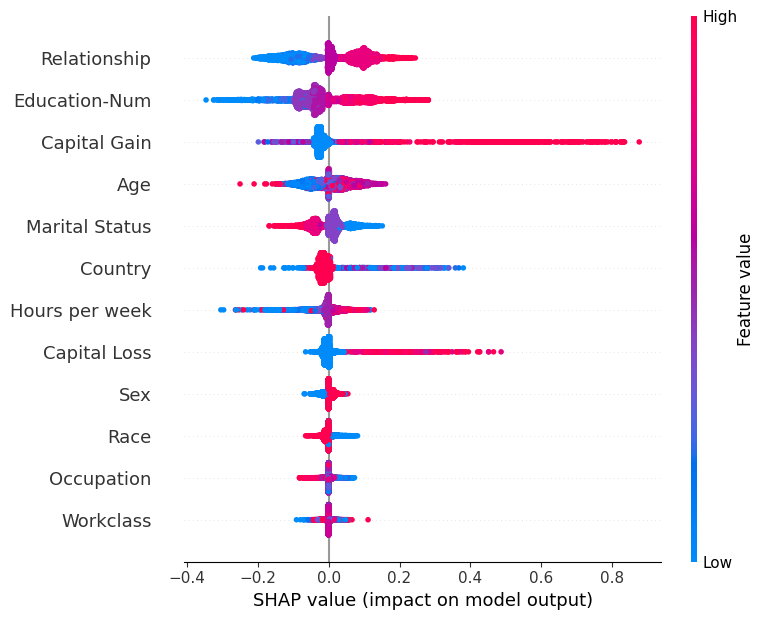

In [ ]:
# Plot SHAP summary plot
shap.summary_plot(mlp_shap_values, X_test_np, feature_names=X_test.columns)

In [ ]:
# Save the SHAP values for MLP
with open('saved_shap/mlp_shap_values_diabetes.pkl', 'wb') as f:
    pickle.dump(mlp_shap_values, f)

## Quantus

### Wrapped model

In [ ]:
# ---------------------------
# Wrap Model for Quantus FaithfulnessCorrelation
# ---------------------------
class TorchMLPModelWrapper(nn.Module):
    def __init__(self, model):
        super(TorchMLPModelWrapper, self).__init__()
        self.model = model
        self.model.eval()

    def forward(self, x):
        return self.model(x)

    def predict(self, X):
        X = np.atleast_2d(X)
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.from_numpy(X).float()
            logits = self.model(X_tensor)
            probs = torch.softmax(logits, dim=1).cpu().numpy()  # shape: (n_samples, 2)
        return probs

    def shape_input(self, x, shape, channel_first):
        return np.atleast_2d(x)

mlp_wrapped_model = TorchMLPModelWrapper(mlp_model)
mlp_wrapped_model.eval()

TorchMLPModelWrapper(
  (model): MLP(
    (fc1): Linear(in_features=22, out_features=50, bias=True)
    (relu): ReLU()
    (fc2): Linear(in_features=50, out_features=2, bias=True)
  )
)

In [ ]:
# ---------------------------
# Evaluate FaithfulnessCorrelation with Quantus using SHAP attributions
# ---------------------------
# Ensure y_test is of integer type
y_test_int = y_test_np.astype(np.int64)

### Complexity

In [ ]:
# Apply Complexity metric using SHAP attributions
Complexity_shap = quantus.Complexity(
    normalise=False,
    abs=True,  # Take absolute values of attributions
    disable_warnings=True,
    display_progressbar=True,
    aggregate_func=np.mean,  # Compute mean complexity over all samples
)(
    model=mlp_wrapped_model,
    x_batch=X_test_np,
    y_batch=y_test_int,
    a_batch=mlp_shap_values,   # use SHAP attributions computed above
    explain_func=None      # explanations are precomputed
)

# Scale to 0-1
Complexity_shap = (Complexity_shap - min(Complexity_shap)) / (
    max(Complexity_shap) - min(Complexity_shap)
)

# Find mean
Complexity_shap = np.mean(Complexity_shap)

print(
    f"Complexity: Complexity by Bhatt et al., 2020.\n"
    f"\n • SHAP = ",
    Complexity_shap,
)

  0%|          | 0/319.0 [00:00<?, ?it/s]

Complexity: Complexity by Bhatt et al., 2020.

 • SHAP =  0.7020995229425601


In [ ]:
Sparseness_shap = quantus.Sparseness(
    normalise=False,
    abs=True, # take absolute values of attributions
    disable_warnings=True,
    display_progressbar=True,
    return_aggregate=True, # find the mean of the complexity from all samples
    aggregate_func=np.mean,
)(
    model=mlp_wrapped_model,
    x_batch=X_test_np,
    y_batch=y_test_int,
    a_batch=mlp_shap_values,   # use SHAP attributions computed above
    explain_func=None,      # explanations are precomputed
)

# Already scaled to 0-1 -> keep aggregated (mean)

print(
    f"Complexity: Sparseness by Chalasani et al., 2020.\n"
    f"\n • SHAP = ",
    Sparseness_shap,
)

  0%|          | 0/319.0 [00:00<?, ?it/s]

Complexity: Sparseness by Chalasani et al., 2020.

 • SHAP =  [np.float64(0.7786418956294339)]


### Faithfulness

In [ ]:
FaithfulnessCorrelation_shap = quantus.FaithfulnessCorrelation(
    perturb_baseline="white",
    perturb_func=quantus.baseline_replacement_by_indices,
    subset_size=5, # features to perturb
    nr_runs=10,
    similarity_func=quantus.similarity_func.correlation_pearson,
    abs=True, # take absolute values of attributions
    normalise=False, # do not normalise ohe data
    return_aggregate=False, # (not) output 1 val instead of list of vals for all samples
    aggregate_func=np.mean,
    disable_warnings=True,
    display_progressbar=True,
)(
    model=mlp_wrapped_model,
    x_batch=X_test_np,
    y_batch=y_test_int,
    a_batch=mlp_shap_values,   # use SHAP attributions computed above
    explain_func=None,      # explanations are precomputed
    device=device
)

print(np.min(FaithfulnessCorrelation_shap))

# Scale to 0-1
FaithfulnessCorrelation_shap = (FaithfulnessCorrelation_shap - np.min(FaithfulnessCorrelation_shap)) / (
    np.max(FaithfulnessCorrelation_shap) - np.min(FaithfulnessCorrelation_shap)
)

# Find mean
FaithfulnessCorrelation_shap = np.mean(FaithfulnessCorrelation_shap)

print(
    f"Faithfulness: Faithfulness Correlation by Bhatt et al., 2020.\n"
    f"\n • SHAP = ",
    FaithfulnessCorrelation_shap,
)

  0%|          | 0/319.0 [00:00<?, ?it/s]

-0.9561000242312457
Faithfulness: Faithfulness Correlation by Bhatt et al., 2020.

 • SHAP =  0.6743308750294664


In [ ]:
FaithfulnessEstimate_shap = quantus.FaithfulnessEstimate(
    perturb_baseline="white",
    perturb_func=quantus.baseline_replacement_by_indices,
    features_in_step=1, # features to perturb
    similarity_func=quantus.similarity_func.correlation_pearson,
    abs=True, # take absolute values of attributions
    normalise=False, # do not normalise ohe data
    return_aggregate=False, # (not) output 1 val instead of list of vals for all samples
    aggregate_func=np.mean,
    disable_warnings=True,
    display_progressbar=True,
)(
    model=mlp_wrapped_model,
    x_batch=X_test_np,
    y_batch=y_test_int,
    a_batch=mlp_shap_values,   # use SHAP attributions computed above
    explain_func=None,      # explanations are precomputed
    device=device
)

# Scale to 0-1
FaithfulnessEstimate_shap = (FaithfulnessEstimate_shap - np.min(FaithfulnessEstimate_shap)) / (
    np.max(FaithfulnessEstimate_shap) - np.min(FaithfulnessEstimate_shap)
)

# Find mean
FaithfulnessEstimate_shap = np.mean(FaithfulnessEstimate_shap)

print(
    f"Faithfulness: Faithfulness Estimate by Alvarez-Melis et al., 2018.\n"
    f"\n • SHAP = ",
    FaithfulnessEstimate_shap,
)

  0%|          | 0/319.0 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/quantus/helpers/warn.py:257: UserWarning: The settings for perturbing input e.g., 'perturb_func' didn't cause change in input. Reconsider the parameter settings.
  warnings.warn(


Faithfulness: Faithfulness Estimate by Alvarez-Melis et al., 2018.

 • SHAP =  0.665840904020447


In [ ]:
FaithfulnessCorrelation_shap = 0.6743308750294664

In [ ]:
FaithfulnessEstimate_shap = 0.665840904020447

### Robustness

In [ ]:
LocalLipschitzEstimate_shap = quantus.LocalLipschitzEstimate(
    normalise=False,
    abs=True, # take absolute values of attributions
    nr_samples = 10,
    disable_warnings=True,
    display_progressbar=True,
    # return_aggregate=True, # find the mean of the complexity from all samples
    #aggregate_func=np.mean,
)(
    model=mlp_wrapped_model,
    x_batch=X_test_np,
    y_batch=y_test_int,
    # a_batch=mlp_shap_values,
    a_batch=None,
    explain_func=quantus.explain,
    explain_func_kwargs={"method": "DeepLift", "reduce_axes": ()},
    device=device
)

# Scale to 0-1
LocalLipschitzEstimate_shap = (LocalLipschitzEstimate_shap - np.min(LocalLipschitzEstimate_shap)) / (
    np.max(LocalLipschitzEstimate_shap) - np.min(LocalLipschitzEstimate_shap)
)

# Find mean
LocalLipschitzEstimate_shap = np.mean(LocalLipschitzEstimate_shap)

print(
    f"Robustness: Local Lipschitz Estimate by Alvarez-Melis et al., 2018.\n"
    f"\n • SHAP = ",
    LocalLipschitzEstimate_shap,
)

  0%|          | 0/319.0 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


Robustness: Local Lipschitz Estimate by Alvarez-Melis et al., 2018.

 • SHAP =  0.07228941334909668


In [ ]:
LocalLipschitzEstimate_shap = 0.07228941334909668

### Randomisation

In [ ]:
RandomLogit_shap = quantus.RandomLogit(
    num_classes=2,
    disable_warnings=True,
    normalise=False,
    abs=True, # take absolute values of attributions
    display_progressbar=True,
    return_aggregate=False, # find the mean of the complexity from all samples
    aggregate_func=np.mean,
)(
    model=mlp_wrapped_model,
    x_batch=X_test_np,
    y_batch=y_test_int,
    a_batch=None,
    explain_func=quantus.explain,
    explain_func_kwargs={"method": "GradientShap", "reduce_axes": ()},
    device=device
)


print(
    f"Randomisation: RandomLogit scores by Sixt et al., 2020.\n"
    f"\n • SHAP = ",
    RandomLogit_shap,
)

print(np.min(RandomLogit_shap))

print(np.max(RandomLogit_shap))

# Scale to 0-1
RandomLogit_shap = (RandomLogit_shap - np.min(RandomLogit_shap)) / (
    np.max(RandomLogit_shap) - np.min(RandomLogit_shap)
)

# Find mean
RandomLogit_shap = np.mean(RandomLogit_shap)

print(
    f"Randomisation: RandomLogit scores by Sixt et al., 2020.\n"
    f"\n • SHAP = ",
    RandomLogit_shap,
)

  0%|          | 0/319.0 [00:00<?, ?it/s]

Randomisation: RandomLogit scores by Sixt et al., 2020.

 • SHAP =  [np.float64(0.9425451457500458), np.float64(0.8493742849677801), np.float64(0.8770511075854301), np.float64(0.8127670153044164), np.float64(0.9067685306072235), np.float64(0.7924696616828442), np.float64(0.8324848655611277), np.float64(0.8566709905862808), np.float64(0.848218996077776), np.float64(0.44242038612719625), np.float64(0.8835972640663385), np.float64(0.8668571747839451), np.float64(0.526126486249268), np.float64(0.9196706861257553), np.float64(0.8176097199320793), np.float64(0.7245913143269718), np.float64(0.937182143330574), np.float64(0.8823828101158142), np.float64(0.7587151098996401), np.float64(0.804782073944807), np.float64(0.8628144850954413), np.float64(0.9243601560592651), np.float64(0.8322573117911816), np.float64(0.8123816419392824), np.float64(0.9389598742127419), np.float64(0.8760839328169823), np.float64(0.8316109664738178), np.float64(0.7822648622095585), np.float64(0.8379814047366381), np.flo

In [ ]:
MPRT_shap = quantus.MPRT(
    # similarity_func=quantus.similarity_func.correlation_spearman,
    return_average_correlation=True,
    # return_aggregate=True, # find the mean of the complexity from all samples
    aggregate_func=np.mean,
    layer_order="independent",
    similarity_func=quantus.ssim,
    disable_warnings=True,
    normalise=False,
    abs=True, # take absolute values of attributions
    display_progressbar=True,
)(
    model=mlp_wrapped_model,
    x_batch=X_test_np,
    y_batch=y_test_int,
    a_batch=None,
    explain_func=quantus.explain,
    explain_func_kwargs={"method": "GradientShap", "reduce_axes": ()},
    device=device
)

# Scale to 0-1
MPRT_shap = (MPRT_shap - np.min(MPRT_shap)) / (
    np.max(MPRT_shap) - np.min(MPRT_shap)
)

# Find mean
MPRT_shap = np.mean(MPRT_shap)

print(
    f"Randomisation: MPRT scores by Adebayo et al., 2018\n"
    f"\n • SHAP = ",
    MPRT_shap,
)

  0%|          | 0/40706 [00:00<?, ?it/s]

Randomisation: MPRT scores by Adebayo et al., 2018

 • SHAP =  0.6990716350107933


In [ ]:
RandomLogit_shap = 0.8101981708403134
MPRT_shap = 0.6990716350107933

### Summary (all)

In [ ]:
# Convert from list to int
Complexity_shap = np.float64(Complexity_shap)
Sparseness_shap = np.float64(Sparseness_shap)
MPRT_shap = np.float64(MPRT_shap)
RandomLogit_shap = np.float64(RandomLogit_shap)
FaithfulnessEstimate_shap = np.float64(FaithfulnessEstimate_shap)
FaithfulnessCorrelation_shap = np.float64(FaithfulnessCorrelation_shap)
LocalLipschitzEstimate_shap = np.float64(LocalLipschitzEstimate_shap)

# Rounding one by one
Complexity_shap = round(float(Complexity_shap), 4)
Sparseness_shap = round(float(Sparseness_shap), 4)
MPRT_shap = round(float(MPRT_shap), 4)
RandomLogit_shap = round(float(RandomLogit_shap), 4)
FaithfulnessEstimate_shap = round(float(FaithfulnessEstimate_shap), 4)
FaithfulnessCorrelation_shap = round(float(FaithfulnessCorrelation_shap), 4)
LocalLipschitzEstimate_shap = round(float(LocalLipschitzEstimate_shap), 4)

<ipython-input-109-acd3cc85ebb0>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Sparseness_shap = round(float(Sparseness_shap), 4)


In [ ]:
display(Markdown("#### Explanability scores"))

# Complexity: Complexity
print(
    f"Complexity: Complexity by Bhatt et al., 2020.\n"
    f"\n • SHAP = ",
    Complexity_shap,
)

# Complexity: Sparseness
print(
    f"Complexity: Sparseness by Chalasani et al., 2020.\n"
    f"\n • SHAP = ",
    Sparseness_shap,
)

# Faithfulness: Faithfulness Estimate
print(
    f"Faithfulness: Faithfulness Estimate by Alvarez-Melis et al., 2018.\n"
    f"\n • SHAP = ",
    FaithfulnessEstimate_shap,
)

# Faithfulness: Faithfulness Correlation
print(
    f"Faithfulness: Faithfulness Correlation by Bhatt et al., 2020.\n"
    f"\n • SHAP = ",
    FaithfulnessCorrelation_shap,
)

# Robustness: Local Lipschitz Estimate
print(
    f"Robustness: Local Lipschitz Estimate by Alvarez-Melis et al., 2018.\n"
    f"\n • SHAP = ",
    LocalLipschitzEstimate_shap,
)

# Randomisation: MPRT
print(
    f"Randomisation: MPRT scores by Adebayo et al., 2018\n"
    f"\n • SHAP = ",
    MPRT_shap,
)

# Randomisation: RandomLogit
print(
    f"Randomisation: RandomLogit scores by Sixt et al., 2020.\n"
    f"\n • SHAP = ",
    RandomLogit_shap,
)

#### Explanability scores

Complexity: Complexity by Bhatt et al., 2020.

 • SHAP =  0.7021
Complexity: Sparseness by Chalasani et al., 2020.

 • SHAP =  0.7786
Faithfulness: Faithfulness Estimate by Alvarez-Melis et al., 2018.

 • SHAP =  0.6658
Faithfulness: Faithfulness Correlation by Bhatt et al., 2020.

 • SHAP =  0.6743
Robustness: Local Lipschitz Estimate by Alvarez-Melis et al., 2018.

 • SHAP =  0.0723
Randomisation: MPRT scores by Adebayo et al., 2018

 • SHAP =  0.6991
Randomisation: RandomLogit scores by Sixt et al., 2020.

 • SHAP =  0.8102


### Summary

In [ ]:
display(Markdown("#### Explanability scores (grouped)"))

# Complexity: Complexity and Sparseness
print(
    f"Complexity"
    f"\n • SHAP = ",
    round(float((Complexity_shap+Sparseness_shap)/2), 4),
)

# Faithfulness: Faithfulness Estimate and Faithfulness Correlation
print(
    f"Faithfulness"
    f"\n • SHAP = ",
    round(float((FaithfulnessEstimate_shap+FaithfulnessCorrelation_shap)/2), 4),
)

# Robustness: Local Lipschitz Estimate
print(
    f"Robustness"
    f"\n • SHAP = ",
    round(float((LocalLipschitzEstimate_shap)), 4),
)

# Randomisation: MPRT and RandomLogit
print(
    f"Randomisation"
    f"\n • SHAP = ",
    round(float((MPRT_shap+RandomLogit_shap)/2), 4)
)

#### Explanability scores (grouped)

Complexity
 • SHAP =  0.7403
Faithfulness
 • SHAP =  0.6701
Robustness
 • SHAP =  0.0723
Randomisation
 • SHAP =  0.7547


# TabResNet

## SHAP

In [ ]:
# ---------------------------
# SHAP Explanation Setup
# ---------------------------
# Define a prediction function for SHAP that returns the probability for class 1.
def f_shap(X):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.from_numpy(np.atleast_2d(X).astype(np.float32))
        X_tensor = X_tensor.to(device)
        logits = model(X_tensor)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        return probs[:, 1]  # return probability for class 1

In [ ]:
# Use a subset of test data as background (e.g., 50 samples)
background = X_test_np[:100]
explainer = shap.KernelExplainer(f_shap, background)

In [ ]:
import pickle

In [ ]:
with open('saved_shap/tabresnet_shap_values_diabetes.pkl', 'rb') as f:
    shap_values = pickle.load(f)

In [ ]:
# Compute SHAP values for the entire test set
shap_values = explainer.shap_values(X_test_np, nsamples=200)

  0%|          | 0/20353 [00:00<?, ?it/s]

<ipython-input-55-4a600d38da37>:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_np, feature_names=X_test.columns)


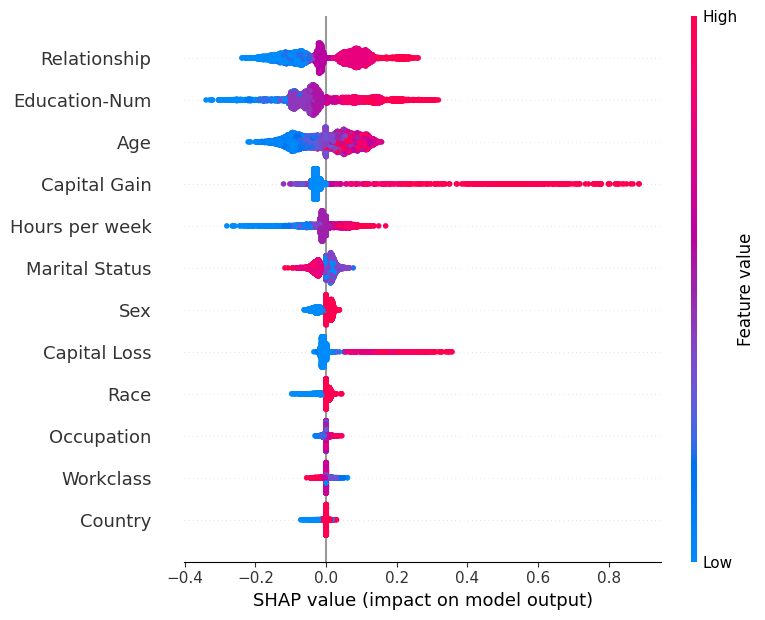

In [ ]:
# shap_values is an array with shape (n_samples, n_features)
shap.summary_plot(shap_values, X_test_np, feature_names=X_test.columns)

In [ ]:
with open('saved_shap/tabresnet_shap_values_diabetes.pkl', 'wb') as f:
    pickle.dump(shap_values, f)

## Quantus

### Wrapped model

In [ ]:
# ---------------------------
# Wrap Model for Quantus FaithfulnessCorrelation
# ---------------------------
class TorchModelWrapper(nn.Module):
    def __init__(self, model):
        super(TorchModelWrapper, self).__init__()
        self.model = model
        self.model.eval()

    def forward(self, x):
        return self.model(x)

    def predict(self, X):
        X = np.atleast_2d(X)
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.from_numpy(X).float()
            logits = self.model(X_tensor)
            probs = torch.softmax(logits, dim=1).cpu().numpy()  # shape: (n_samples, 2)
        return probs

    def shape_input(self, x, shape, channel_first):
        return np.atleast_2d(x)

wrapped_model = TorchModelWrapper(model)
wrapped_model.eval()

TorchModelWrapper(
  (model): TabResNet(
    (input_projection): Linear(in_features=22, out_features=16, bias=True)
    (resblocks): ModuleList(
      (0-1): 2 x TabResBlock(
        (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (ln1): Linear(in_features=16, out_features=32, bias=True)
        (relu1): ReLU()
        (drop1): Dropout(p=0.2, inplace=False)
        (ln2): Linear(in_features=32, out_features=16, bias=True)
        (drop2): Dropout(p=0.05, inplace=False)
      )
    )
    (predblock): Sequential(
      (0): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)

In [ ]:
# ---------------------------
# Evaluate FaithfulnessCorrelation with Quantus using SHAP attributions
# ---------------------------
# Ensure y_test is of integer type
y_test_int = y_test_np.astype(np.int64)

### Complexity

In [ ]:
# Apply Complexity metric using SHAP attributions
Complexity_shap = quantus.Complexity(
    normalise=False,
    abs=True,  # Take absolute values of attributions
    disable_warnings=True,
    display_progressbar=True,
    aggregate_func=np.mean,  # Compute mean complexity over all samples
)(
    model=wrapped_model,
    x_batch=X_test_np,
    y_batch=y_test_int,
    a_batch=shap_values,   # use SHAP attributions computed above
    explain_func=None      # explanations are precomputed
)

# Scale to 0-1
Complexity_shap = (Complexity_shap - min(Complexity_shap)) / (
    max(Complexity_shap) - min(Complexity_shap)
)

# Find mean
Complexity_shap = np.mean(Complexity_shap)

print(
    f"Complexity: Complexity by Bhatt et al., 2020.\n"
    f"\n • SHAP = ",
    Complexity_shap,
)

  0%|          | 0/319.0 [00:00<?, ?it/s]

Complexity: Complexity by Bhatt et al., 2020.

 • SHAP =  0.7438448292615909


In [ ]:
Sparseness_shap = quantus.Sparseness(
    normalise=False,
    abs=True, # take absolute values of attributions
    disable_warnings=True,
    display_progressbar=True,
    return_aggregate=True, # find the mean of the complexity from all samples
    aggregate_func=np.mean,
)(
    model=wrapped_model,
    x_batch=X_test_np,
    y_batch=y_test_int,
    a_batch=shap_values,   # use SHAP attributions computed above
    explain_func=None      # explanations are precomputed
)

# Already scaled to 0-1 -> keep aggregated (mean)

print(
    f"Complexity: Sparseness by Chalasani et al., 2020.\n"
    f"\n • SHAP = ",
    Sparseness_shap,
)

  0%|          | 0/319.0 [00:00<?, ?it/s]

Complexity: Sparseness by Chalasani et al., 2020.

 • SHAP =  [np.float64(0.7607571720322581)]


### Faithfulness

In [ ]:
FaithfulnessCorrelation_shap = quantus.FaithfulnessCorrelation(
    perturb_baseline="white",
    perturb_func=quantus.baseline_replacement_by_indices,
    subset_size=5, # features to perturb
    nr_runs=10,
    similarity_func=quantus.similarity_func.correlation_pearson,
    abs=True, # take absolute values of attributions
    normalise=False, # do not normalise ohe data
    return_aggregate=False, # (not) output 1 val instead of list of vals for all samples
    aggregate_func=np.mean,
    disable_warnings=True,
    display_progressbar=True,
)(
    model=wrapped_model,
    x_batch=X_test_np,
    y_batch=y_test_int,
    a_batch=shap_values,   # use SHAP attributions computed above
    explain_func=None,      # explanations are precomputed
    device=device
)

# Scale to 0-1
FaithfulnessCorrelation_shap = (FaithfulnessCorrelation_shap - np.min(FaithfulnessCorrelation_shap)) / (
    np.max(FaithfulnessCorrelation_shap) - np.min(FaithfulnessCorrelation_shap)
)

# Find mean
FaithfulnessCorrelation_shap = np.mean(FaithfulnessCorrelation_shap)

print(
    f"Faithfulness: Faithfulness Correlation by Bhatt et al., 2020.\n"
    f"\n • SHAP = ",
    FaithfulnessCorrelation_shap,
)

  0%|          | 0/319.0 [00:00<?, ?it/s]

Faithfulness: Faithfulness Correlation by Bhatt et al., 2020.

 • SHAP =  0.715409511264135


In [ ]:
FaithfulnessEstimate_shap = quantus.FaithfulnessEstimate(
    perturb_baseline="white",
    perturb_func=quantus.baseline_replacement_by_indices,
    features_in_step=1, # features to perturb
    similarity_func=quantus.similarity_func.correlation_pearson,
    abs=True, # take absolute values of attributions
    normalise=False, # do not normalise ohe data
    return_aggregate=False, # (not) output 1 val instead of list of vals for all samples
    aggregate_func=np.mean,
    disable_warnings=True,
    display_progressbar=True,
)(
    model=wrapped_model,
    x_batch=X_test_np,
    y_batch=y_test_int,
    a_batch=shap_values,   # use SHAP attributions computed above
    explain_func=None,      # explanations are precomputed
    device=device
)

# Scale to 0-1
FaithfulnessEstimate_shap = (FaithfulnessEstimate_shap - np.min(FaithfulnessEstimate_shap)) / (
    np.max(FaithfulnessEstimate_shap) - np.min(FaithfulnessEstimate_shap)
)

# Find mean
FaithfulnessEstimate_shap = np.mean(FaithfulnessEstimate_shap)

print(
    f"Faithfulness: Faithfulness Estimate by Alvarez-Melis et al., 2018.\n"
    f"\n • SHAP = ",
    FaithfulnessEstimate_shap,
)

  0%|          | 0/319.0 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/quantus/helpers/warn.py:257: UserWarning: The settings for perturbing input e.g., 'perturb_func' didn't cause change in input. Reconsider the parameter settings.
  warnings.warn(


Faithfulness: Faithfulness Estimate by Alvarez-Melis et al., 2018.

 • SHAP =  0.7699729437562299


### Robustness

In [ ]:
LocalLipschitzEstimate_shap = quantus.LocalLipschitzEstimate(
    normalise=False,
    abs=True, # take absolute values of attributions
    nr_samples = 20,
    disable_warnings=True,
    display_progressbar=True,
    # return_aggregate=True, # find the mean of the complexity from all samples
    aggregate_func=np.mean,
)(
    model=wrapped_model,
    x_batch=X_test_np,
    y_batch=y_test_int,
    # a_batch=shap_values,   # use SHAP attributions computed above
    # explain_func=None      # explanations are precomputed
    a_batch=None,
    explain_func=quantus.explain,
    explain_func_kwargs={"method": "DeepLift", "reduce_axes": ()},
    device=device
)

# Scale to 0-1
LocalLipschitzEstimate_shap = (LocalLipschitzEstimate_shap - np.min(LocalLipschitzEstimate_shap)) / (
    np.max(LocalLipschitzEstimate_shap) - np.min(LocalLipschitzEstimate_shap)
)

# Find mean
LocalLipschitzEstimate_shap = np.mean(LocalLipschitzEstimate_shap)

print(
    f"Robustness: Local Lipschitz Estimate by Alvarez-Melis et al., 2018.\n"
    f"\n • SHAP = ",
    LocalLipschitzEstimate_shap,
)

  0%|          | 0/319.0 [00:00<?, ?it/s]

Robustness: Local Lipschitz Estimate by Alvarez-Melis et al., 2018.

 • SHAP =  0.12395134568590836


### Randomisation

In [ ]:
RandomLogit_shap = quantus.RandomLogit(
    num_classes=2,
    disable_warnings=True,
    normalise=False,
    abs=True, # take absolute values of attributions
    display_progressbar=True,
    return_aggregate=False, # find the mean of the complexity from all samples
    aggregate_func=np.mean,
)(
    model=wrapped_model,
    x_batch=X_test_np,
    y_batch=y_test_int,
    a_batch=None,
    explain_func=quantus.explain,
    explain_func_kwargs={"method": "GradientShap", "reduce_axes": ()},
    device=device
)


print(
    f"Randomisation: RandomLogit scores by Sixt et al., 2020.\n"
    f"\n • SHAP = ",
    RandomLogit_shap,
)

print(np.min(RandomLogit_shap))

print(np.max(RandomLogit_shap))

# Scale to 0-1
RandomLogit_shap = (RandomLogit_shap - np.min(RandomLogit_shap)) / (
    np.max(RandomLogit_shap) - np.min(RandomLogit_shap)
)

# Find mean
RandomLogit_shap = np.mean(RandomLogit_shap)

print(
    f"Randomisation: RandomLogit scores by Sixt et al., 2020.\n"
    f"\n • SHAP = ",
    RandomLogit_shap,
)

  0%|          | 0/319.0 [00:00<?, ?it/s]

Randomisation: RandomLogit scores by Sixt et al., 2020.

 • SHAP =  [np.float64(0.3939600745216012), np.float64(0.6371792163699865), np.float64(0.370085867238231), np.float64(0.3420071585569531), np.float64(0.14246822358109057), np.float64(0.554326344281435), np.float64(0.2454642034135759), np.float64(0.09828553209081292), np.float64(0.6316756224259734), np.float64(0.8337843641638756), np.float64(0.2580713299685158), np.float64(0.6319931959733367), np.float64(0.657951844856143), np.float64(0.4029167639091611), np.float64(0.7113154903054237), np.float64(0.654070233926177), np.float64(0.44766529207117856), np.float64(0.3123487897682935), np.float64(0.6055189110338688), np.float64(0.567906690761447), np.float64(0.7128754388540983), np.float64(0.791481152176857), np.float64(0.19091622717678547), np.float64(0.44597055297344923), np.float64(0.6077418504282832), np.float64(0.5884758420288563), np.float64(0.29738228529458866), np.float64(0.5787106715142727), np.float64(0.27275358684710227), np

In [ ]:
MPRT_shap = quantus.MPRT(
    # similarity_func=quantus.similarity_func.correlation_spearman,
    return_average_correlation=True,
    # return_aggregate=True, # find the mean of the complexity from all samples
    aggregate_func=np.mean,
    layer_order="independent",
    similarity_func=quantus.ssim,
    disable_warnings=True,
    normalise=False,
    abs=True, # take absolute values of attributions
    display_progressbar=True,
)(
    model=wrapped_model,
    x_batch=X_test_np,
    y_batch=y_test_int,
    # a_batch=shap_values,   # use SHAP attributions computed above
    # explain_func=None      # explanations are precomputed
    a_batch=None,
    explain_func=quantus.explain,
    explain_func_kwargs={"method": "GradientShap", "reduce_axes": ()},
    device=device
)

# Scale to 0-1
MPRT_shap = (MPRT_shap - np.min(MPRT_shap)) / (
    np.max(MPRT_shap) - np.min(MPRT_shap)
)

# Find mean
MPRT_shap = np.mean(MPRT_shap)

print(
    f"Randomisation: MPRT scores by Adebayo et al., 2018\n"
    f"\n • SHAP = ",
    MPRT_shap,
)

  0%|          | 0/183177 [00:00<?, ?it/s]

Randomisation: MPRT scores by Adebayo et al., 2018

 • SHAP =  0.6120010427359958


### Summary (all)

In [ ]:
# Convert from list to int
Complexity_shap = np.float64(Complexity_shap)
Sparseness_shap = np.float64(Sparseness_shap)
MPRT_shap = np.float64(MPRT_shap)
RandomLogit_shap = np.float64(RandomLogit_shap)
FaithfulnessEstimate_shap = np.float64(FaithfulnessEstimate_shap)
FaithfulnessCorrelation_shap = np.float64(FaithfulnessCorrelation_shap)
LocalLipschitzEstimate_shap = np.float64(LocalLipschitzEstimate_shap)

# Rounding one by one
Complexity_shap = round(float(Complexity_shap), 4)
Sparseness_shap = round(float(Sparseness_shap), 4)
MPRT_shap = round(float(MPRT_shap), 4)
RandomLogit_shap = round(float(RandomLogit_shap), 4)
FaithfulnessEstimate_shap = round(float(FaithfulnessEstimate_shap), 4)
FaithfulnessCorrelation_shap = round(float(FaithfulnessCorrelation_shap), 4)
LocalLipschitzEstimate_shap = round(float(LocalLipschitzEstimate_shap), 4)

In [ ]:
display(Markdown("#### Explanability scores"))

# Complexity: Complexity
print(
    f"Complexity: Complexity by Bhatt et al., 2020.\n"
    f"\n • SHAP = ",
    Complexity_shap,
)

# Complexity: Sparseness
print(
    f"Complexity: Sparseness by Chalasani et al., 2020.\n"
    f"\n • SHAP = ",
    Sparseness_shap,
)

# Faithfulness: Faithfulness Estimate
print(
    f"Faithfulness: Faithfulness Estimate by Alvarez-Melis et al., 2018.\n"
    f"\n • SHAP = ",
    FaithfulnessEstimate_shap,
)

# Faithfulness: Faithfulness Correlation
print(
    f"Faithfulness: Faithfulness Correlation by Bhatt et al., 2020.\n"
    f"\n • SHAP = ",
    FaithfulnessCorrelation_shap,
)

# Robustness: Local Lipschitz Estimate
print(
    f"Robustness: Local Lipschitz Estimate by Alvarez-Melis et al., 2018.\n"
    f"\n • SHAP = ",
    LocalLipschitzEstimate_shap,
)

# Randomisation: MPRT
print(
    f"Randomisation: MPRT scores by Adebayo et al., 2018\n"
    f"\n • SHAP = ",
    MPRT_shap,
)

# Randomisation: RandomLogit
print(
    f"Randomisation: RandomLogit scores by Sixt et al., 2020.\n"
    f"\n • SHAP = ",
    RandomLogit_shap,
)

#### Explanability scores

Complexity: Complexity by Bhatt et al., 2020.

 • SHAP =  0.7438
Complexity: Sparseness by Chalasani et al., 2020.

 • SHAP =  0.7608
Faithfulness: Faithfulness Estimate by Alvarez-Melis et al., 2018.

 • SHAP =  0.77
Faithfulness: Faithfulness Correlation by Bhatt et al., 2020.

 • SHAP =  0.7154
Robustness: Local Lipschitz Estimate by Alvarez-Melis et al., 2018.

 • SHAP =  0.124
Randomisation: MPRT scores by Adebayo et al., 2018

 • SHAP =  0.612
Randomisation: RandomLogit scores by Sixt et al., 2020.

 • SHAP =  0.6212


### Summary

In [ ]:
display(Markdown("#### Explanability scores (grouped)"))

# Complexity: Complexity and Sparseness
print(
    f"Complexity"
    f"\n • SHAP = ",
    round(float((Complexity_shap+Sparseness_shap)/2), 4),
)

# Faithfulness: Faithfulness Estimate and Faithfulness Correlation
print(
    f"Faithfulness"
    f"\n • SHAP = ",
    round(float((FaithfulnessEstimate_shap+FaithfulnessCorrelation_shap)/2), 4),
)

# Robustness: Local Lipschitz Estimate
print(
    f"Robustness"
    f"\n • SHAP = ",
    round(float((LocalLipschitzEstimate_shap)), 4),
)

# Randomisation: MPRT and RandomLogit
print(
    f"Randomisation"
    f"\n • SHAP = ",
    round(float((MPRT_shap+RandomLogit_shap)/2), 4)
)

#### Explanability scores (grouped)

Complexity
 • SHAP =  0.7523
Faithfulness
 • SHAP =  0.7427
Robustness
 • SHAP =  0.124
Randomisation
 • SHAP =  0.6166
